In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict

import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [3]:
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'
path_genes='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/'
path_save=path_data+'model_comparison/'
path_save_markers=path_save+'marker_plots/'

In [4]:
# Saving figures
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'
sc._settings.ScanpyConfig.figdir=Path(path_fig)

In [5]:
adata_rn_b=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad')
adata_rn_b.shape

(102143, 30672)

## Prepare data

Sample categories - healthy or diabetic model per dataste

In [6]:
# T1D and T2D (untreated) samples by diabetes model vs healthy controls from same studies
diseased_category={
 'NOD_elimination_SRR7610300_14w':'NOD',
 'NOD_elimination_SRR7610299_14w':'NOD',
 'NOD_elimination_SRR7610298_14w':'NOD',
 'NOD_elimination_SRR7610303_16w':'NOD',
 'NOD_elimination_SRR7610301_16w':'NOD',
 'NOD_elimination_SRR7610302_16w':'NOD',
 'NOD_elimination_SRR7610295_8w':'healthy control (NOD)',
 'NOD_elimination_SRR7610296_8w':'healthy control (NOD)',
 'NOD_elimination_SRR7610297_8w':'healthy control (NOD)',
 'VSG_MUC13633_chow_WT':'healthy control (db/db)',
 'VSG_MUC13634_chow_WT':'healthy control (db/db)',
 'VSG_MUC13641_sham_Lepr-/-':'db/db',
 'VSG_MUC13639_sham_Lepr-/-':'db/db',
 'STZ_G2_STZ':'mSTZ',
 'STZ_G1_control':'healthy control (mSTZ)'}
diseased_order_colors={'healthy control (mSTZ)':'#0CA9BD',
                       'healthy control (db/db)':'#0B2E79',
                       'healthy control (NOD)':'#8BBD0C',
                       'mSTZ':'#FFCC57',
                       'db/db':'#C72323',
                       'NOD':'#8D29A4'}
adata_rn_b_sub=adata_rn_b[np.argwhere(adata_rn_b.obs.study_sample_design.isin(
    diseased_category.keys()).values).ravel(),:].copy()
adata_rn_b_sub.obs['diseased_group']=pd.Categorical(
    adata_rn_b_sub.obs.study_sample_design.map(diseased_category),
    categories=diseased_order_colors.keys(),ordered=True)
# Add colors so that PAGA recognises them
#adata_rn_b_sub.uns['diseased_group_colors']=diseased_order_colors
adata_rn_b_sub.uns['diseased_group_colors']=[diseased_order_colors[c] for c in  
                                             adata_rn_b_sub.obs['diseased_group'].cat.categories]

In [83]:
 # reorder categories
adata_rn_b_sub.obs['diseased_group']=pd.Categorical(
adata_rn_b_sub.obs.study_sample_design.map(diseased_category),
categories=['healthy control (NOD)','NOD',
            'healthy control (mSTZ)','mSTZ',
            'healthy control (db/db)','db/db']
    ,ordered=True)

## Markers

Extract markers from manually currated tables

In [7]:
# orthologues info
orthologues=pd.read_table(path_genes+'orthologues_ORGmus_musculus_ORG2homo_sapiens_V103.tsv'
                         ).rename({'Gene stable ID':'eid_mm','Human gene name':'gs_hs'},axis=1)

In [6]:
# Load markers
markers_func=pd.read_excel(path_genes+'markers.xlsx',sheet_name='beta_function')
markers_pheno=pd.read_excel(path_genes+'markers.xlsx',sheet_name='beta_heterogeneity')

In [8]:
def get_mm_eid(x):
    # Parsing of marker data rows (x) to get mouse EID
    gs=set()
    for i,data in x.iterrows():
        g=data.gene_name
        if data.organism=='Homo sapiens':
            g=set(adata_rn_b.var.loc[
            set(orthologues.query('gs_hs in @g')['eid_mm']),'gene_symbol'])
        else:
            g={g}
        gs.update(g)
    return gs

In [9]:
# Get markers 
functions=['UPR','immune modulation','ROS defense',
           'insulin synthesis and processing','insulin secretion']
phenotypes=['mature','senescent']
# Get symbols from mouse
def get_mm_eid(x):
    gs=set()
    for i,data in x.iterrows():
        g=data.gene_name
        if data.organism=='Homo sapiens':
            g=set(adata_rn_b.var.loc[
            set(orthologues.query('gs_hs in @g')['eid_mm']),'gene_symbol'])
        else:
            g={g}
        gs.update(g)
    return gs
# retrieve markers per group
marker_sel=pd.concat([
    markers_func.query('function in @functions'
                       ).groupby(['function','function_specific'],dropna=False
                                )[['gene_name','organism']].apply(
    lambda x: get_mm_eid(x)),
    markers_pheno.query('subtype in @phenotypes'
                       ).groupby(['subtype'])[['gene_name','organism']].apply(
    lambda x: get_mm_eid(x))
])
# Remove empty groups
marker_sel=marker_sel[marker_sel.apply(lambda x: len(x)>0 )]
# Group for plotting
marker_sel=marker_sel.reset_index()
marker_sel['group_main']=marker_sel['index'].apply(lambda x:x if isinstance(x,str) else x[0])
marker_sel['group_sub']=marker_sel['index'].apply(
    lambda x: None if isinstance(x,str) else x[1]).fillna('/')
gene_groups={}
for group,data in marker_sel.groupby('group_main'):
    if data.shape[0]<2:
        gene_groups[group]=sorted(list(*data[0]))
    else:
        gene_groups[group]={gr:sorted(list(*gs[0])) for gr,gs in data.groupby('group_sub')}

Plot all markers for each marker group

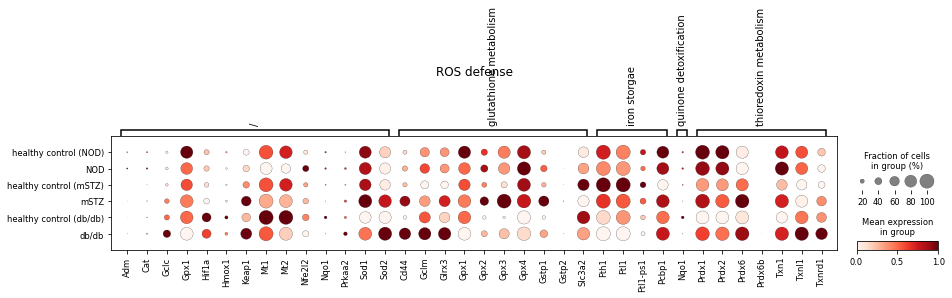

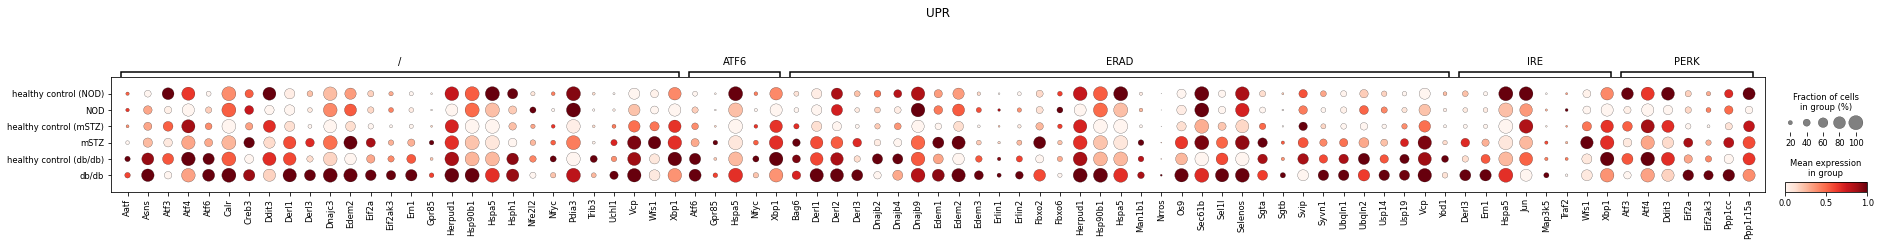

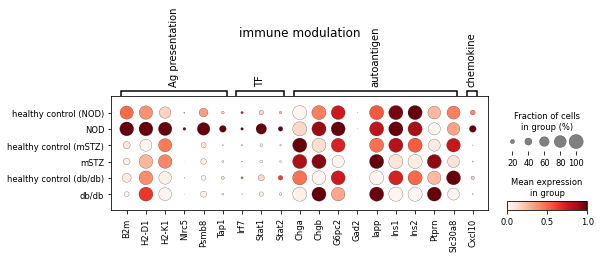

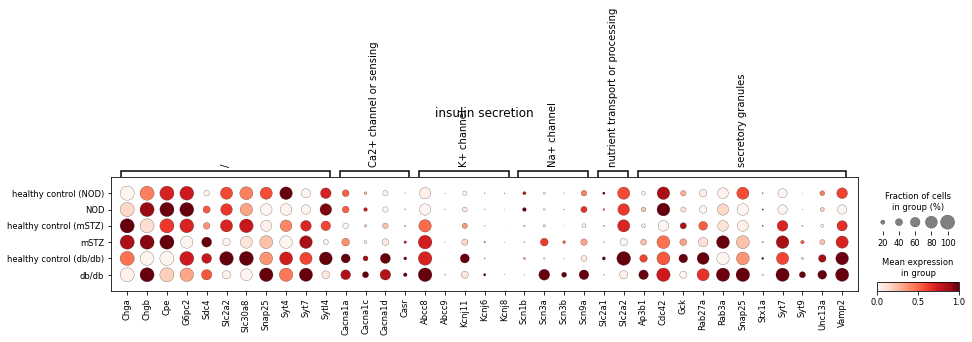

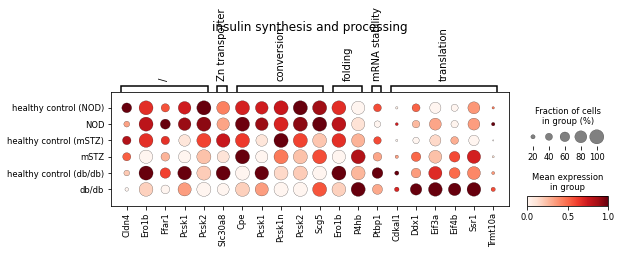

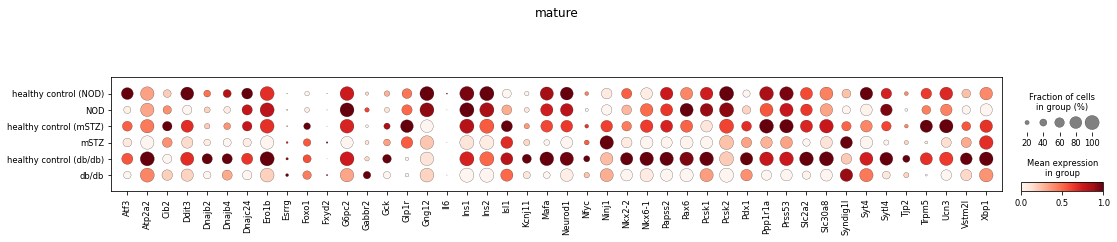

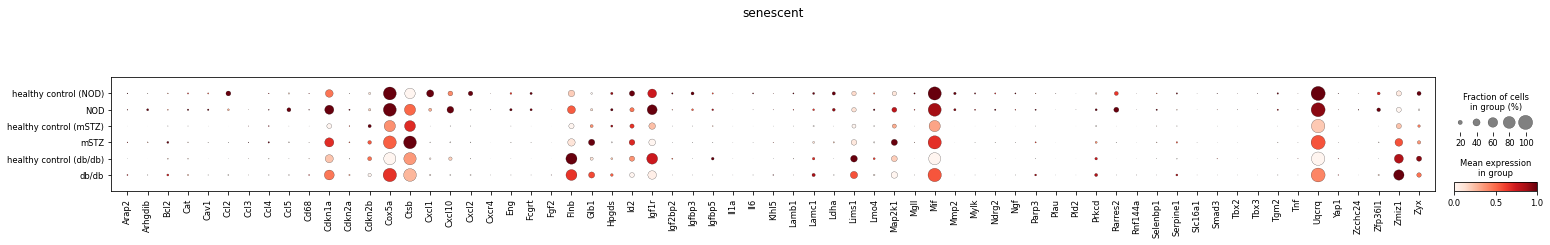

In [84]:
# plot per main group
for group,genes in gene_groups.items():
    sc.pl.dotplot(adata_rn_b_sub[:,adata_rn_b_sub.var.gene_symbol_original_matched!='Ddit3-1'], 
              var_names=genes,
                         gene_symbols='gene_symbol',use_raw=False,
              groupby='diseased_group',
              standard_scale='var',title=group,
              show=False)
    plt.savefig(path_save_markers+group.replace(' ','_')+'.png',dpi=300,bbox_inches='tight')

C: This needs to be pruned down - not all stress responses are informative, autoantigens are involved in other functions (not T1D), some genes are not well known for easy understanding, ... 

Subset of genes (manually selected) to plot in paper for brevity

In [9]:
# get selected genes
genes=pd.read_excel(path_save_markers+'gene_list_selected.xlsx',
                    sheet_name='beta cell functional and stress',index_col=0)
genes=genes[~genes['group_final2'].isna()]
# get gene groups
genes=genes.groupby('group').apply(lambda x:list(x.index))

# Set group ordering
n_groups=genes.shape[0]
genes=genes[['mature','insulin secretion','insulin synthesis and processing',
            'UPR','ROS defense','senescent','immune modulation']]
if n_groups<genes.shape[0]:
    raise valueError('Missing gene group in ordering')

# Reorder some genes
# Slc2a2 mature at the end
l=genes['mature']
oldindex=np.argwhere(np.array(l)=='Slc2a2')[0][0]
newindex=len(l)-1
l.insert(newindex, l.pop(oldindex))
# Cxcl10 immune at the start
l=genes['immune modulation']
oldindex=np.argwhere(np.array(l)=='Cxcl10')[0][0]
newindex=0
l.insert(newindex, l.pop(oldindex))

print(genes)

# Make dict
genes=genes.to_dict()

# Replace name with newline after each space
genes={k.replace(' ','\n'):v for k,v in genes.items()}

group
mature                                   [Ins1, Mafa, Pax6, Ucn3, Slc2a2]
insulin secretion                          [G6pc2, Slc30a8, Snap25, Syt4]
insulin synthesis and processing            [Ero1b, Ffar1, Pcsk1, Pcsk1n]
UPR                                             [Atf3, Atf4, Hspa5, Xbp1]
ROS defense                                       [Mt1, Sod1, Gpx1, Gpx2]
senescent                           [Bcl2, Cdkn1a, Igfbp3, Il6, Serpine1]
immune modulation                            [Cxcl10, H2-K1, Tap1, Stat1]
dtype: object


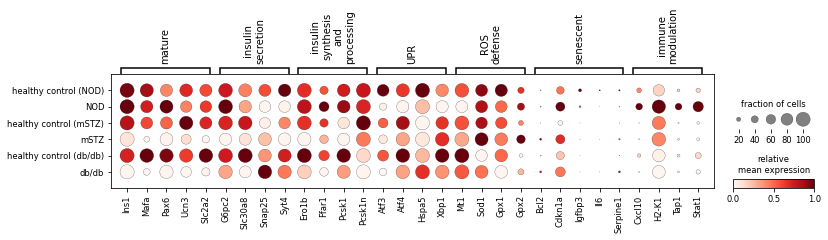

In [11]:
# Plot marker subset
sc.pl.dotplot(adata_rn_b_sub, 
              var_names=genes,
                         gene_symbols='gene_symbol',use_raw=False,
              groupby='diseased_group',
              standard_scale='var',show=False,
              size_title='fraction of cells',
              colorbar_title='relative\nmean expression',)
plt.savefig(path_fig+'dotplot_beta_diabModelComparison_knownFMarkers.png',dpi=300,
                bbox_inches='tight')